## Laptop Price Prediction

In [1]:
# Import Modules
import re
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from IPython.display import clear_output
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso


#### Get Dataset from Kaggle

In [2]:
# Download Dataset
!mkdir dataset
%cd dataset
!kaggle datasets download -d muhammetvarl/laptop-price
clear_output()


In [3]:
# Unzip Dataset
!tar -xf laptop-price.zip


In [4]:
# Delete Unwanted Files
!del laptop-price.zip
%cd ..
clear_output()


#### Loading Data in Pandas Dataframe

In [5]:
data_df = pd.read_csv('dataset/laptop_price.csv', index_col='laptop_ID', encoding='latin-1')
data_df = data_df.drop(columns=['Product'])


In [6]:
# Check Missing Values
print(f'Dataset has {data_df.isnull().sum().sum()} missing values')

# Check Duplicate Data
print(f'Dataset has {data_df.duplicated().sum()} duplicate records')


Dataset has 0 missing values
Dataset has 29 duplicate records


In [7]:
# Remove Duplicate Records
data_df = data_df.drop_duplicates()


#### Feature Extraction

In [8]:
# View Dataframe
data_df


,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
laptop_ID,,,,,,,,,,,
1,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
2,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
3,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
4,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
5,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60
...,...,...,...,...,...,...,...,...,...,...,...
1287,Asus,Notebook,15.6,1366x768,Intel Core i7 6500U 2.5GHz,4GB,500GB HDD,Nvidia GeForce 920M,Windows 10,2.2kg,720.32
1288,Lenovo,2 in 1 Convertible,14.0,IPS Panel Full HD / Touchscreen 1920x1080,Intel Core i7 6500U 2.5GHz,4GB,128GB SSD,Intel HD Graphics 520,Windows 10,1.8kg,638.00
1289,Lenovo,2 in 1 Convertible,13.3,IPS Panel Quad HD+ / Touchscreen 3200x1800,Intel Core i7 6500U 2.5GHz,16GB,512GB SSD,Intel HD Graphics 520,Windows 10,1.3kg,1499.00


Creating Column for TouchScreen, which is True if Laptop has Touch Screen, False otherwise

In [9]:
data_df['Touch Screen'] = data_df['ScreenResolution'].apply(lambda x: 'touchscreen' in x.lower())


Creating Column for IPS Panel, which is True if Laptop has IPS Panel Screen, False otherwise

In [10]:
data_df['IPS_Panel'] = data_df['ScreenResolution'].apply(lambda x: 'IPS' in x)


Extracting Pixels as ints in Width and Height

In [11]:
# Screen Resolution in '/d+x/d+' form
data_df['ScreenResolution'] = data_df['ScreenResolution'].apply(lambda x: re.findall('\d+x\d+', x)[0])

# Pixels in Width and Height
data_df[['X_pixels', 'Y_pixels']] = data_df.apply(lambda x: x['ScreenResolution'].split('x'), axis=1, result_type='expand').astype('int32')

# Dropping Screen Resolution (it became redundant)
data_df = data_df.drop(columns=['ScreenResolution'])


Extracting CPU Type

In [12]:
def extract_CPUtype(text):
    text = text.lower()

    # 3 Types of Intel CPUs [i3, i5, i7]
    if 'intel' in text:
        if 'core i3' in text:
            return 'Intel Core i3'
        elif 'core i5' in text:
            return 'Intel Core i5'
        elif 'core i7' in text:
            return 'Intel Core i7'
        else:
            return 'Intel Other'

    # AMD CPUs
    elif 'amd' in text:
        return 'AMD'

    # Other CPUs
    else:
        return 'Other'


data_df['Cpu'] = data_df['Cpu'].apply(lambda x: extract_CPUtype(x))


Extracting RAM as int in GB

In [13]:
data_df['Ram'] = data_df['Ram'].apply(lambda x: x.replace('GB', '')).astype('int32')


Extracting Storage Capacity

In [14]:
def extract_storage_capacity(text):
    # Change 'Flash Storage' to 'Flash_Storage'
    text = text.replace('Flash Storage', 'Flash_Storage')

    # Different Storage types are sepatated by + symbol
    text = text.split('+')
    text = [x.strip() for x in text]

    storage = {}
    for word in text:
        capacity, storage_type = word.split()

        # Get Capacity in int
        capacity = capacity.replace('.0', '')
        capacity = capacity.replace('GB', '')
        capacity = capacity.replace('TB', '000')
        capacity = int(capacity)

        storage[storage_type] = capacity

    return storage


storage_df = data_df.apply(lambda x: extract_storage_capacity(x['Memory']), axis=1, result_type='expand')
storage_df = storage_df.fillna(0).astype('int32')

data_df = pd.concat([data_df, storage_df], axis=1)

# Dropping Memory (it became redundant)
data_df = data_df.drop(columns=['Memory'])


Extracting GPU Type

In [15]:
data_df['Gpu'] = data_df['Gpu'].apply(lambda x: x.split()[0])


Extracting Operating System Type

In [16]:
def extract_operating_system(text):
    text = text.lower()

    if 'windows' in text:
        return 'Windows'
    elif 'mac' in text:
        return 'MAC'
    else:
        return 'Other'


data_df['OpSys'] = data_df['OpSys'].apply(lambda x: extract_operating_system(x))


Extracting Weight as int in kg

In [17]:
data_df['Weight'] = data_df['Weight'].apply(lambda x: x.replace('kg', '')).astype('float32')


In [18]:
# View Dataframe
data_df


,Company,TypeName,Inches,Cpu,Ram,Gpu,OpSys,Weight,Price_euros,Touch Screen,IPS_Panel,X_pixels,Y_pixels,SSD,Flash_Storage,HDD,Hybrid
laptop_ID,,,,,,,,,,,,,,,,,
1,Apple,Ultrabook,13.3,Intel Core i5,8,Intel,MAC,1.37,1339.69,False,True,2560,1600,128,0,0,0
2,Apple,Ultrabook,13.3,Intel Core i5,8,Intel,MAC,1.34,898.94,False,False,1440,900,0,128,0,0
3,HP,Notebook,15.6,Intel Core i5,8,Intel,Other,1.86,575.00,False,False,1920,1080,256,0,0,0
4,Apple,Ultrabook,15.4,Intel Core i7,16,AMD,MAC,1.83,2537.45,False,True,2880,1800,512,0,0,0
5,Apple,Ultrabook,13.3,Intel Core i5,8,Intel,MAC,1.37,1803.60,False,True,2560,1600,256,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1287,Asus,Notebook,15.6,Intel Core i7,4,Nvidia,Windows,2.20,720.32,False,False,1366,768,0,0,500,0
1288,Lenovo,2 in 1 Convertible,14.0,Intel Core i7,4,Intel,Windows,1.80,638.00,True,True,1920,1080,128,0,0,0
1289,Lenovo,2 in 1 Convertible,13.3,Intel Core i7,16,Intel,Windows,1.30,1499.00,True,True,3200,1800,512,0,0,0


#### Data Visualization

Count Plot of Categorical Features

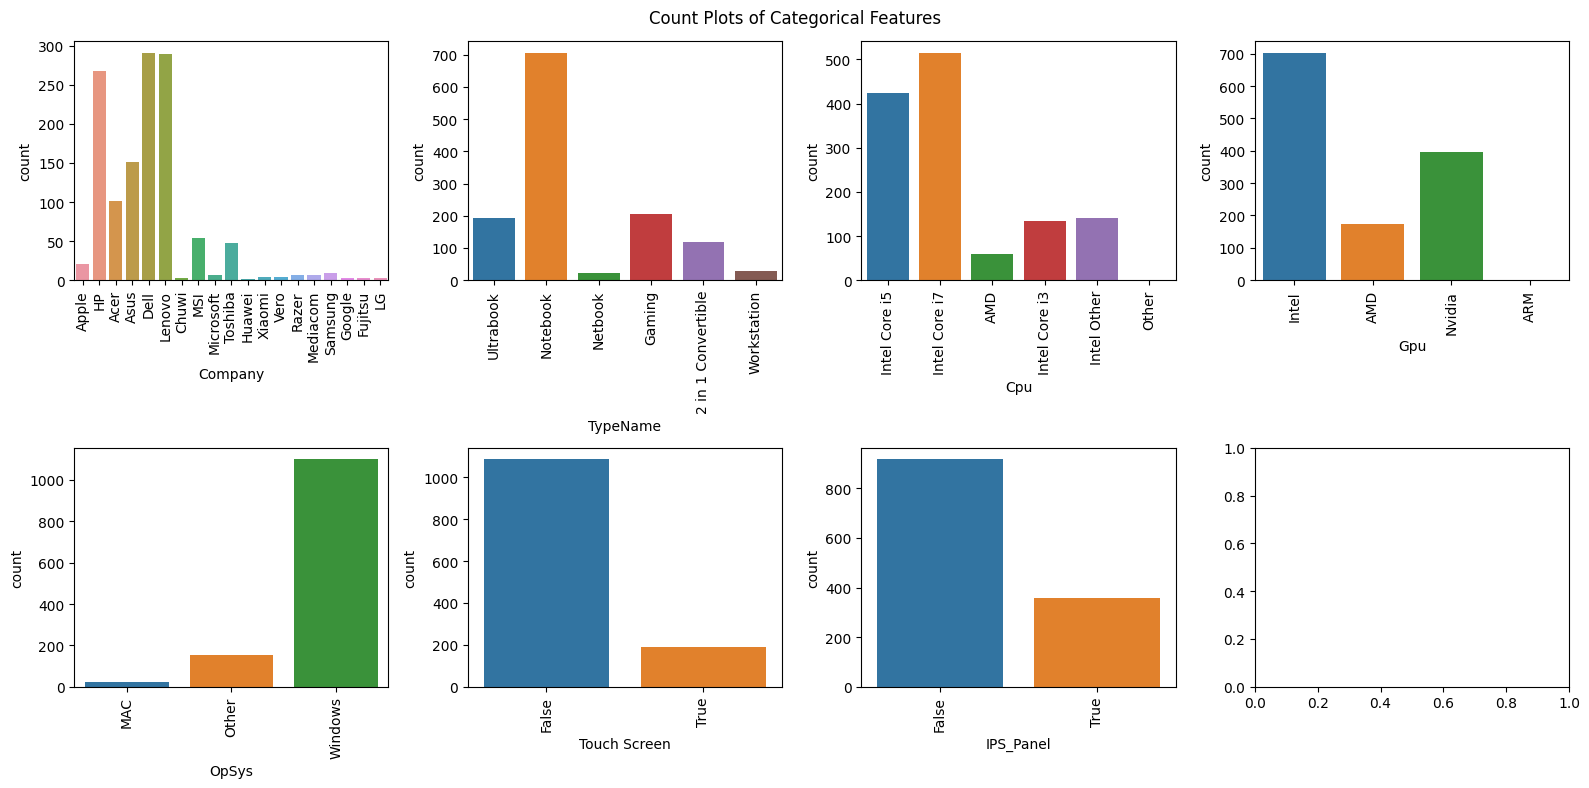

In [19]:
categorical_features = data_df.select_dtypes(include=['object', 'bool']).columns

fig, ax = plt.subplots(math.ceil(len(categorical_features)/4), 4, figsize=(16, 8))
fig.suptitle('Count Plots of Categorical Features')

for i, feature in enumerate(categorical_features):
    sns.countplot(data_df, x=feature, ax=ax[i//4][i % 4], palette=None)
    ax[i//4][i % 4].tick_params(axis='x', labelrotation=90)

fig.tight_layout()


Distribution Plot of Numerical Features

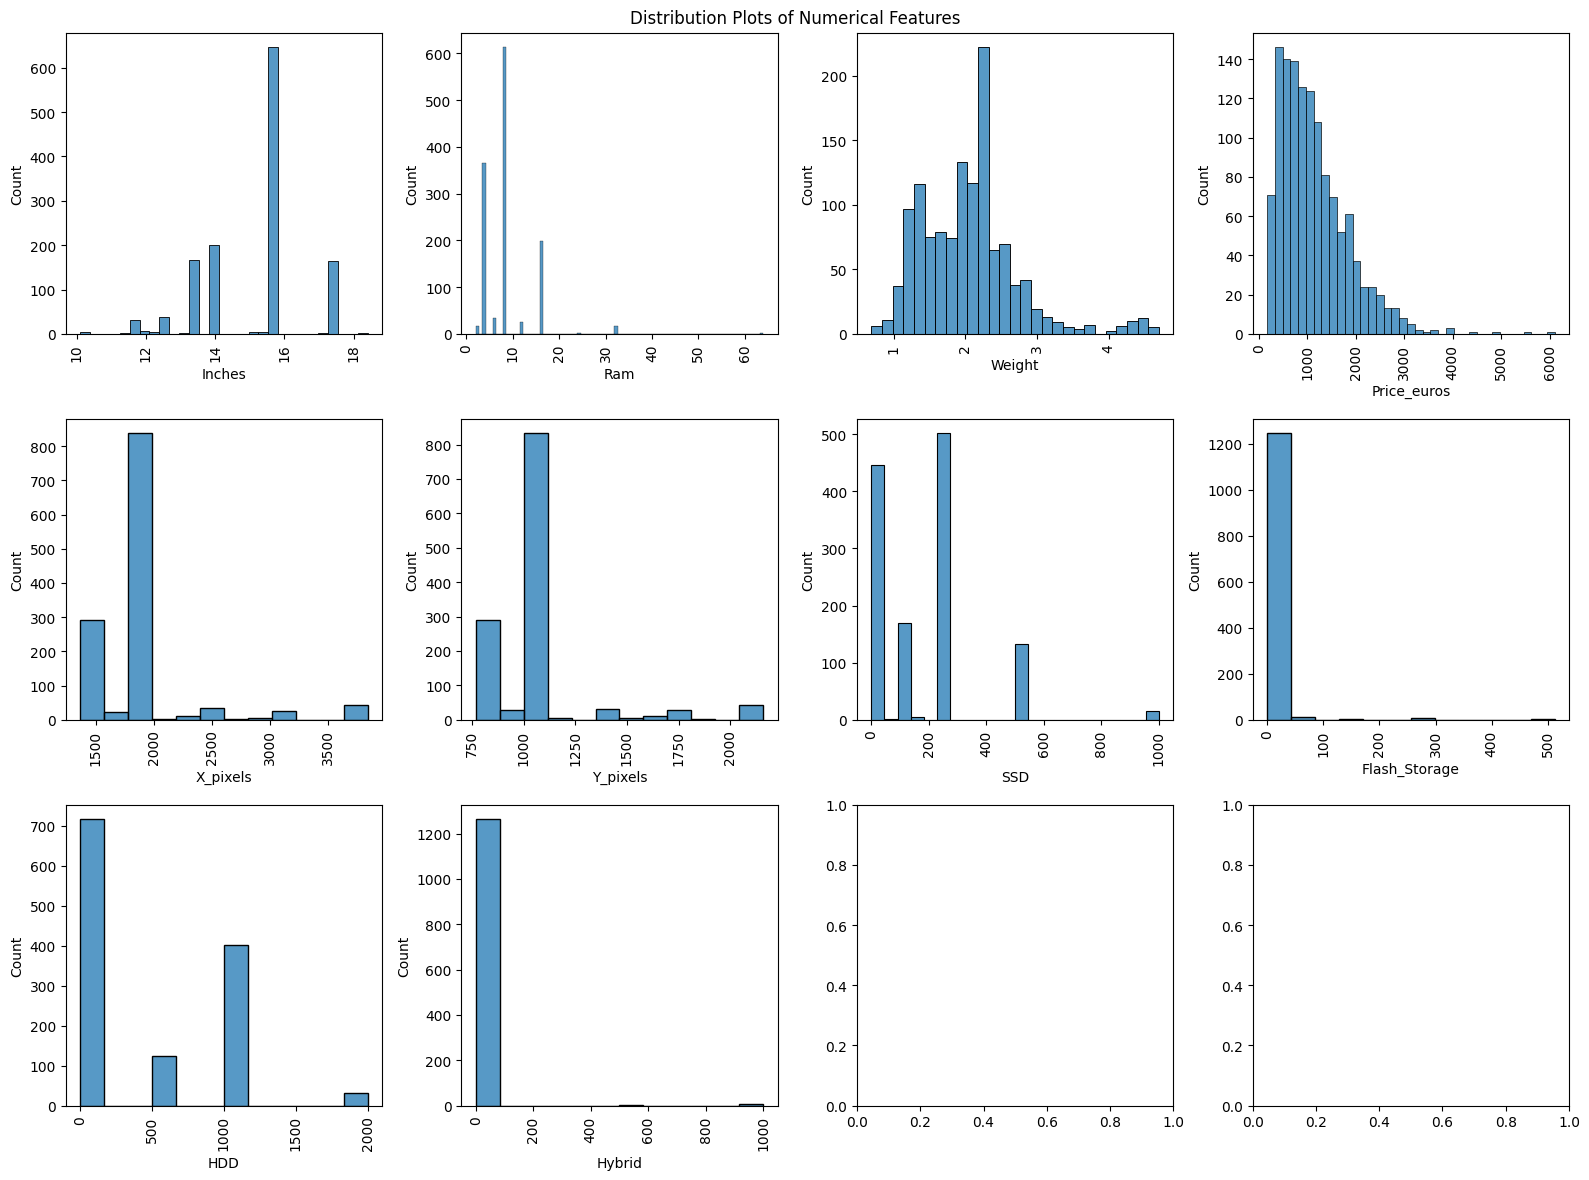

In [20]:
numerical_features = data_df.select_dtypes(include=['int32', 'int64', 'float32', 'float64']).columns

fig, ax = plt.subplots(math.ceil(len(numerical_features)/4), 4, figsize=(16, 12))
fig.suptitle('Distribution Plots of Numerical Features')

for i, feature in enumerate(numerical_features):
    sns.histplot(data_df, x=feature, ax=ax[i//4][i % 4], palette=None)
    ax[i//4][i % 4].tick_params(axis='x', labelrotation=90)

fig.tight_layout()


- Distribution of Price is Left Skewed
- Applying log function on Price will make it centrally skewed

<Axes: xlabel='log(Price_euros)', ylabel='Count'>

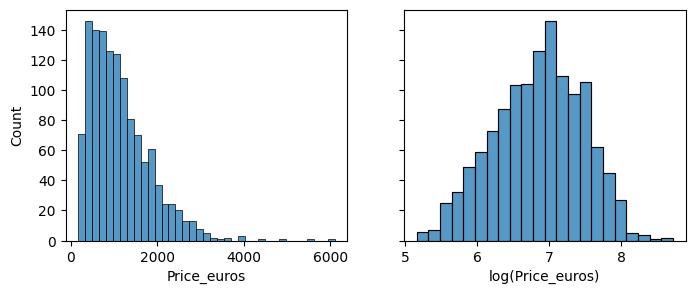

In [21]:
# Comparing Distribuition of Price and Log(Price)
data = data_df['Price_euros'].apply(lambda x: math.log(x))
data.name = 'log(Price_euros)'

fig, ax = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
sns.histplot(data_df, x='Price_euros', ax=ax[0])
sns.histplot(x=data, ax=ax[1])


In [22]:
# Check Count for CPU
data_df['Cpu'].value_counts()


Cpu
Intel Core i7    515
Intel Core i5    423
Intel Other      141
Intel Core i3    134
AMD               60
Other              1
Name: count, dtype: int64

In [23]:
# Removing the only Sample with Other CPU
data_df = data_df.drop(data_df[data_df['Cpu'] == 'Other'].index)


In [24]:
# Check Count for GPU
data_df['Gpu'].value_counts()


Gpu
Intel     703
Nvidia    396
AMD       174
Name: count, dtype: int64

#### Data Analysis

Variation of Price against Categorical Features (95% Confidence)

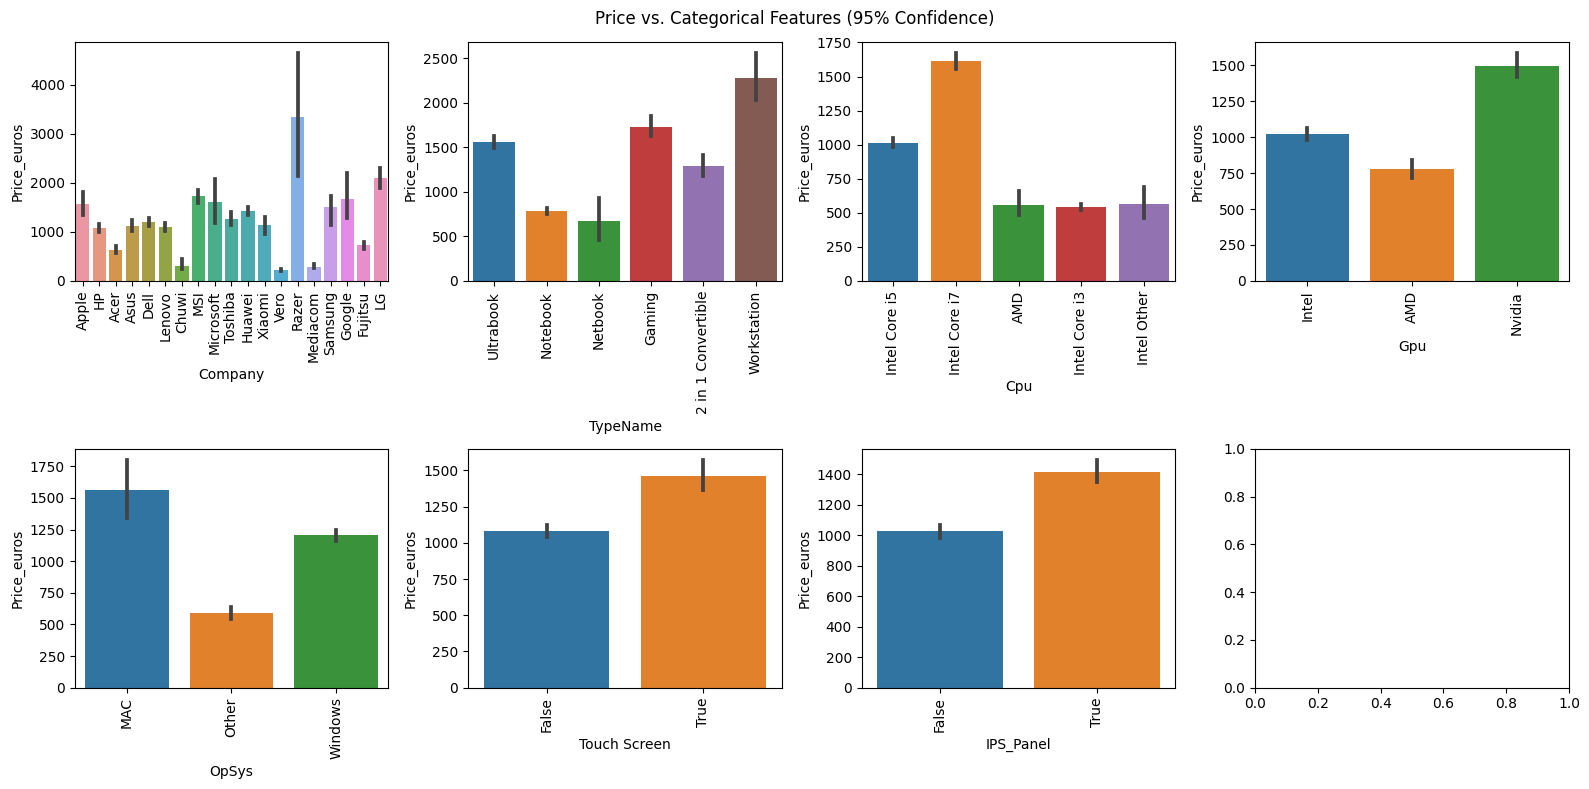

In [25]:
fig, ax = plt.subplots(math.ceil(len(categorical_features)/4), 4, figsize=(16, 8))
fig.suptitle('Price vs. Categorical Features (95% Confidence)')

for i, feature in enumerate(categorical_features):
    sns.barplot(data_df, x=feature, y='Price_euros', ax=ax[i//4][i % 4], palette=None)
    ax[i//4][i % 4].tick_params(axis='x', labelrotation=90)

fig.tight_layout()


- Notebook, the most popular Type of Laptop has very competitive pricing
- Laptops with Intel i7 CPU and Nvidia GPU are the most Expensive
- Apple's MAC Books are more expensive than Windows Notebooks
- Laptops with Touch Screen or IPS Panel are more expensive, as expected

Variation of Price against Numerical Features (95% Confidence)

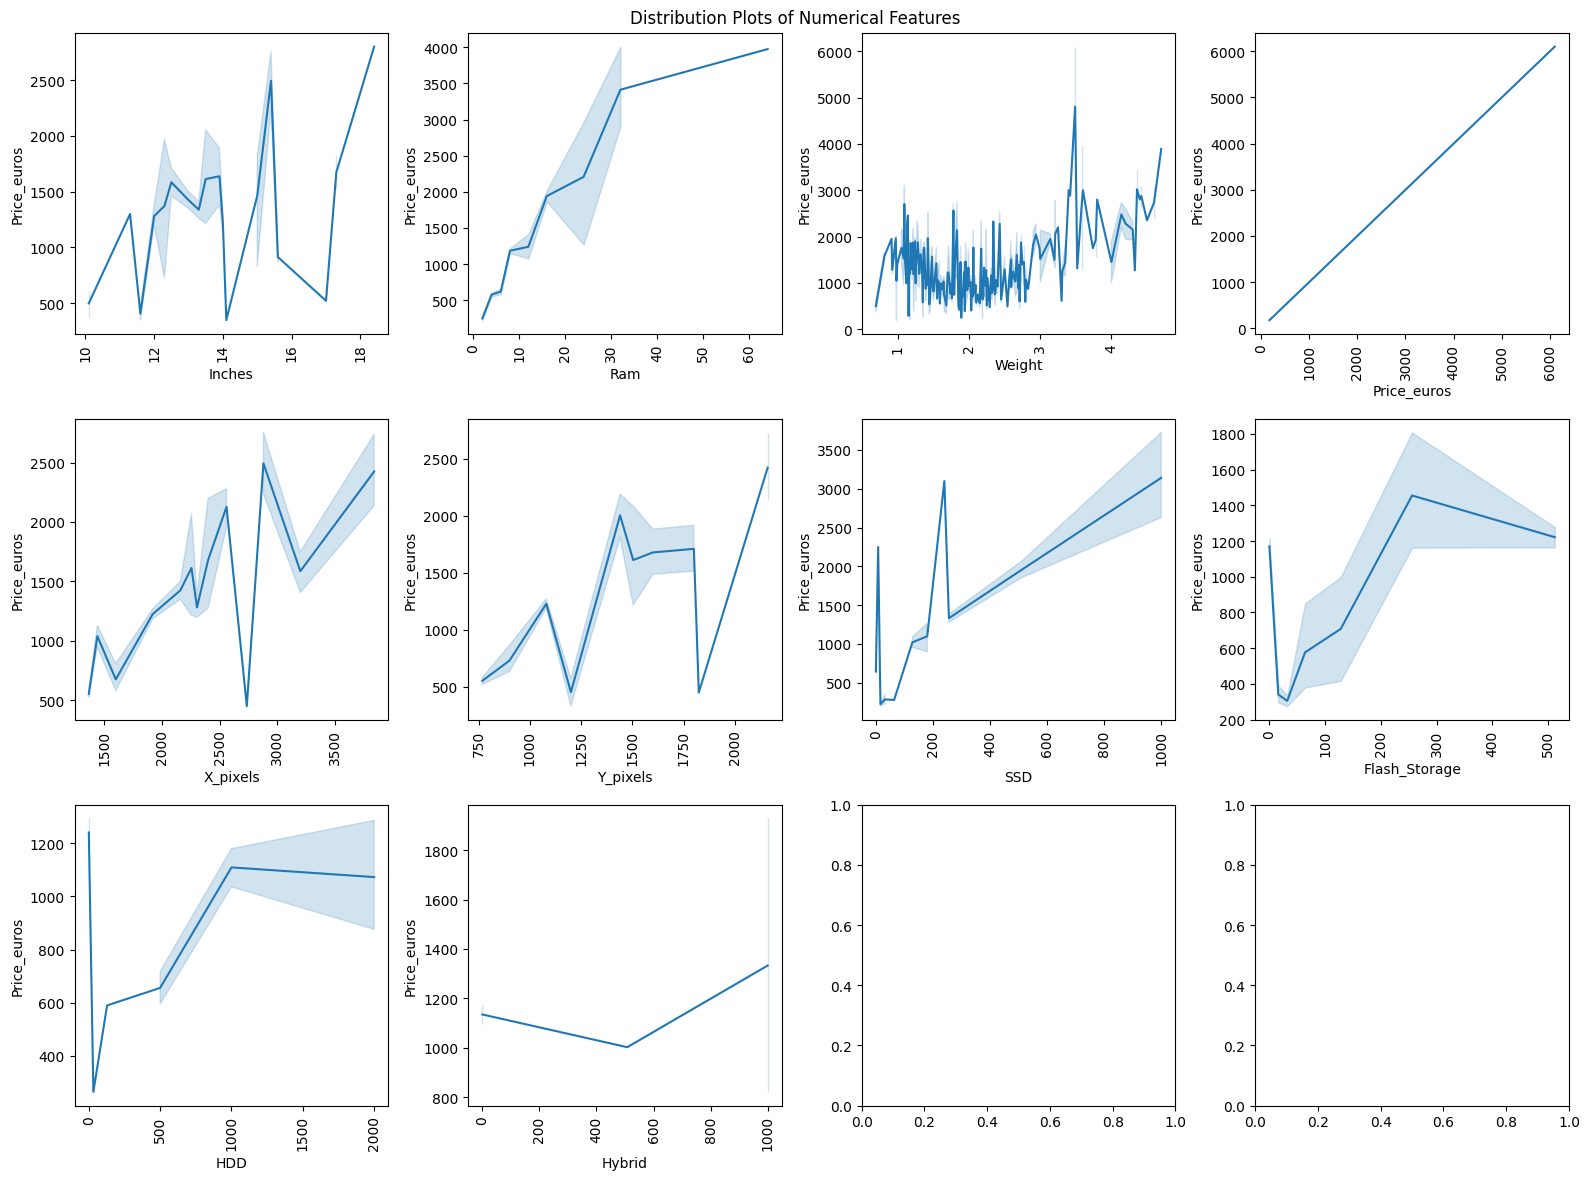

In [26]:
fig, ax = plt.subplots(math.ceil(len(numerical_features)/4), 4, figsize=(16, 12))
fig.suptitle('Distribution Plots of Numerical Features')

for i, feature in enumerate(numerical_features):
    sns.lineplot(data_df, x=feature, y='Price_euros', ax=ax[i//4][i % 4])
    ax[i//4][i % 4].tick_params(axis='x', labelrotation=90)

fig.tight_layout()


- Price has good relation with RAM and SSD Capacities

Correlation Matrix

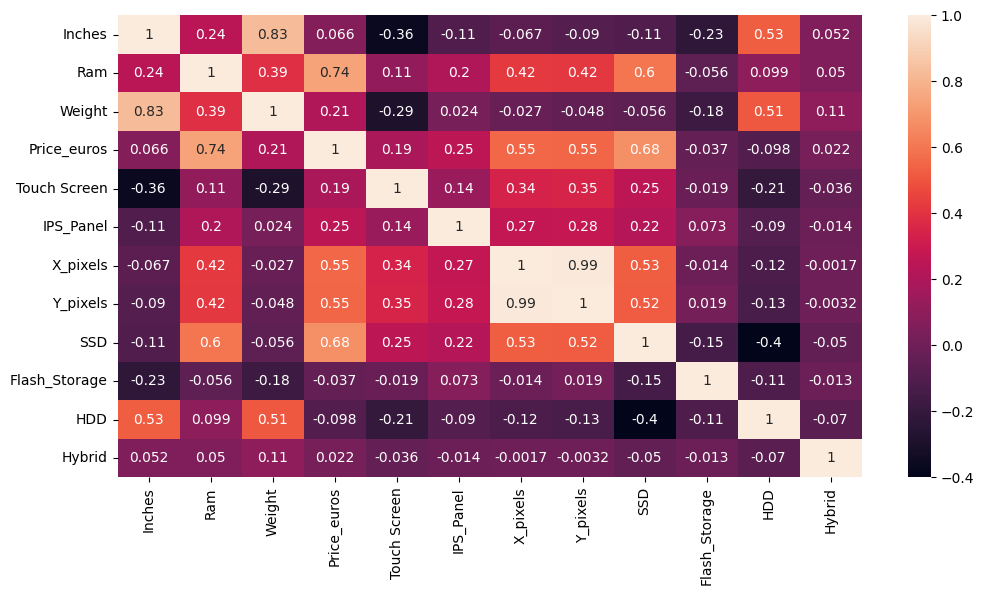

In [27]:
fig, ax = plt.subplots(figsize=(12, 6))
_ = sns.heatmap(data_df.corr(numeric_only=True), annot=True, ax=ax)


- Price has high correlation with RAM and SSD capacities
- Price has low correlation with Flash and Hybrid Storage capacities
- X_Pixels and Y_Pixels are higly Correlated, this is epected as screen resolutions are mostly standardized
- X_Pixels, Y_Pixels and Screensize will be combined to create Pixels per Inch (PPI)

$$
PPI = \frac{Diagonal\ in\ Pixels}{Diagonal\ in\ Inches} = \frac{\sqrt{X\ Pixels^2 + Y\ Pixels^2}}{Diagonal\ in\ Inches}
$$

In [28]:
# Dropping Features with low Correlation
data_df = data_df.drop(columns=['Flash_Storage', 'Hybrid'])


In [29]:
# Creating Feature Pixels per Inch

data_df['PPI'] = (data_df['X_pixels']**2 + data_df['Y_pixels']**2) ** 0.5 / data_df['Inches']
data_df = data_df.drop(columns=['X_pixels', 'Y_pixels', 'Inches'])


Correlation Matrix

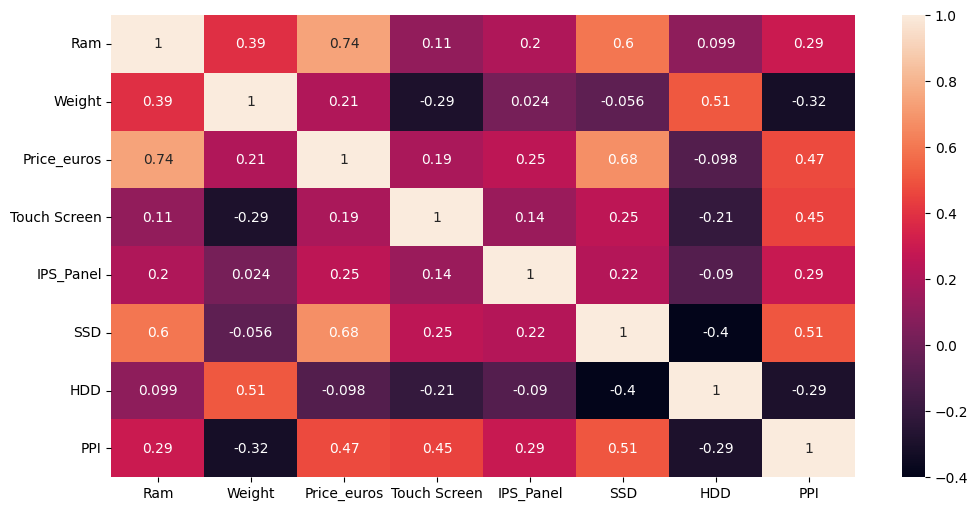

In [30]:
fig, ax = plt.subplots(figsize=(12, 6))
_ = sns.heatmap(data_df.corr(numeric_only=True), annot=True, ax=ax)


- Correlation of PPI with price is better than average of it's individual components

#### Setting Up Data

In [31]:
X = data_df.drop(columns=['Price_euros'])
Y = data_df['Price_euros'].apply(lambda x: math.log(x))


One Hot Encoding of Categorical Features

In [32]:
encoder = ColumnTransformer(transformers=[('encoder', OneHotEncoder(sparse_output=False), categorical_features)],
                            remainder='passthrough',
                            n_jobs=-1)
X = encoder.fit_transform(X)

# Saving encoder data for Web Application
enc_file = open('encoder_data.txt', 'w')
for feature, categories in zip(categorical_features, encoder.named_transformers_['encoder'].categories_):
    enc_file.write(feature+' '+str(len(categories))+'\n')
    for category in categories:
        enc_file.write(str(category)+'\n')
enc_file.close()


In [33]:
# Splitting Dataset into Training and Testing Sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15)


#### Modelling

In [34]:
# Defining Models
MODELS = {'Linear Regression': LinearRegression(),
          'Ridge Regression': Ridge(),
          'Lasso Regression': Lasso(),
          'Decision Tree': DecisionTreeRegressor(max_depth=8),
          'Random Forest': RandomForestRegressor(n_estimators=64,
                                                 max_samples=0.5,
                                                 max_features=0.75,
                                                 max_depth=12,
                                                 n_jobs=-1)}


In [35]:
# Training Models
for model in MODELS:
    MODELS[model].fit(X_train, Y_train)


#### Model Evaluation

In [36]:
# Calculating R2 Scores and Mean Absolute Errors on Test Set
METRICS = pd.DataFrame(index=MODELS.keys(), columns=['R2 Score', 'MAE'])

for model in MODELS:
    Y_pred = MODELS[model].predict(X_test)

    METRICS.loc[model] = {'R2 Score' : metrics.r2_score(Y_test, Y_pred),
                          'MAE': metrics.mean_absolute_error(Y_test, Y_pred)}


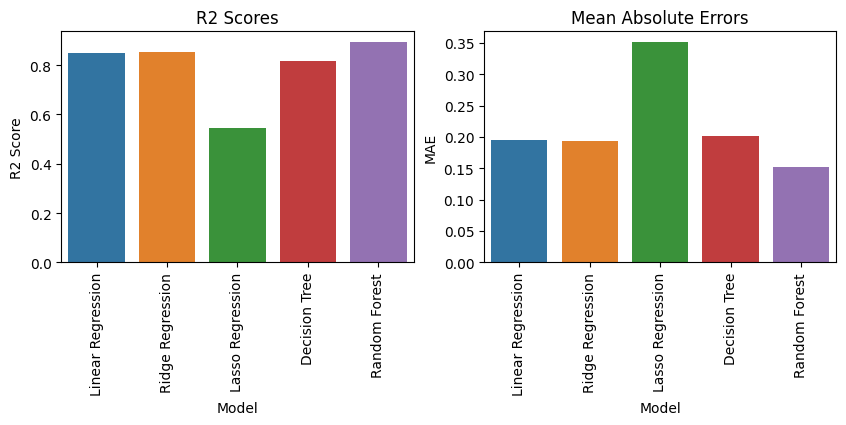

In [37]:
# Comparing Metrics
def plot_metric(df, title, y_label, ax):
    ax.set_title(title)
    ax.set_xlabel('Model')
    ax.set_ylabel(y_label)
    ax.tick_params(axis='x', labelrotation=90)

    sns.barplot(df, x=df.index, y=y_label, ax=ax)

fig, ax = plt.subplots(1, 2, figsize=(10, 3))
plot_metric(METRICS, 'R2 Scores', 'R2 Score', ax[0])
plot_metric(METRICS, 'Mean Absolute Errors', 'MAE', ax[1])
